In [1]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
import os 
from statsmodels.stats import multitest

statspath = '/Users/nicolasfarrugia/Documents/recherche/git/pd_osc_decoding/alldata_proba/'

Step 0 - preparing data 

fields for the saved stats files are : 
- scores
- proba
- pval
- U

For each of them, layout is 4 (Regreg,RegIrreg,IrregReg,IrregIrreg) x CV x TestTime x TrainTime

In [5]:
allsubj = os.listdir(statspath)

In [6]:
allsubj

['180523_01c1_formal_conditionwise.npz',
 '180523_01k1_formal_conditionwise.npz',
 '180523_01m1_formal_conditionwise.npz',
 '180523_02c1_formal_conditionwise.npz',
 '180523_02k1_formal_conditionwise.npz',
 '180523_02m1_formal_conditionwise.npz',
 '180523_03c1_formal_conditionwise.npz',
 '180523_03k1_formal_conditionwise.npz',
 '180523_03m1_formal_conditionwise.npz',
 '180523_04c1_formal_conditionwise.npz',
 '180523_04k1_formal_conditionwise.npz',
 '180523_04m1_formal_conditionwise.npz',
 '180523_05c1_formal_conditionwise.npz',
 '180523_05k1_formal_conditionwise.npz',
 '180523_06c1_formal_conditionwise.npz',
 '180523_06k1_formal_conditionwise.npz',
 '180523_07c1_formal_conditionwise.npz',
 '180523_07k1_formal_conditionwise.npz',
 '180523_08c1_formal_conditionwise.npz',
 '180523_08k1_formal_conditionwise.npz',
 '180523_09c1_formal_conditionwise.npz',
 '180523_09k1_formal_conditionwise.npz',
 '180523_10c1_formal_conditionwise.npz',
 '180523_10k1_formal_conditionwise.npz',
 '180523_11c1_fo

Group files per subject type (patients or control) 

In [8]:
controls_id = []
patients_id = []

for cursubj in allsubj:
    if (cursubj[9]=='k'):
        controls_id.append(cursubj)
    else:
        patients_id.append(cursubj)
            

Step 1 - Analysis of "Diagonal" Classification

In [95]:
def diagonal_group(subjlist,statspath):


    diag_sig_fdr_all = []
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([np.diag(curmat) for curmat in curpvals]) # extract diagonal classification

        diag_sig_fdr = []
        for curdiag in diag_pvals:
            H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
            diag_sig_fdr.append(H)

        diag_sig_fdr_all.append(np.stack(diag_sig_fdr))
        
        
    
    return np.sum(np.stack(diag_sig_fdr_all),axis=0)

In [96]:
diag_sig_fdr_controls = diagonal_group(controls_id,statspath)
diag_sig_fdr_patients = diagonal_group(patients_id,statspath)

Create the time vector

In [98]:
tmin = -0.05
tmax = 0.52

timevec = np.linspace(tmin,tmax,diag_sig_fdr_controls.shape[1])

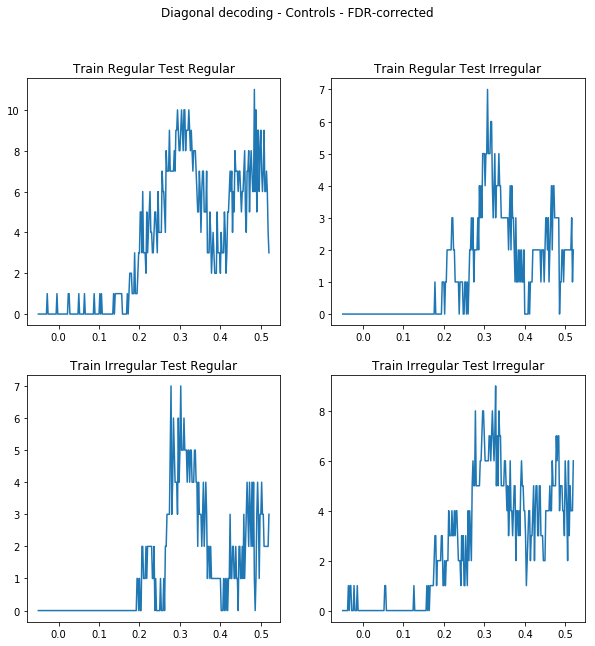

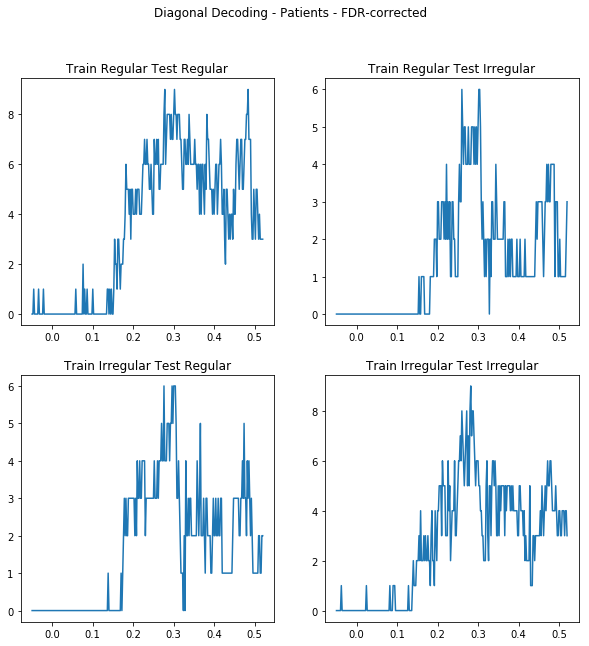

In [99]:
subtitles = ['Train Regular Test Regular',
            'Train Regular Test Irregular',
            'Train Irregular Test Regular',
            'Train Irregular Test Irregular']


plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(timevec,diag_sig_fdr_controls[i-1])
    plt.title(subtitles[i-1])
plt.suptitle('Diagonal decoding - Controls - FDR-corrected')
plt.show()


plt.figure(figsize=(10,10))


for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(timevec,diag_sig_fdr_patients[i-1])
    plt.title(subtitles[i-1])
plt.suptitle('Diagonal Decoding - Patients - FDR-corrected')
plt.show()

Objective : find a reasonable min / max time window in which diagonal classification is significant for everyone. 

Step 2 - Average duration of significant generalization

In the time window for which diagonal classification is significant for everyone, investigate every 100 ms whether there is temporal generalization. 

In [37]:
def offdiagonal_group(subjlist,statspath,timepoint):


    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([curmat[timepoint,:] for curmat in curpvals]) # extract a line from the matrix 

        diag_sig_fdr = []
        for curdiag in diag_pvals:
            H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
            diag_sig_fdr.append(H)

        return np.stack(diag_sig_fdr)

In [65]:
tp=0.300
tp_ind = 175
### Find the index corresponding to this timepoint 
print(timevec[tp_ind])

0.3


In [76]:
tp_ind2 = 225
### Find the index corresponding to this timepoint 
print(timevec[tp_ind2])

0.4


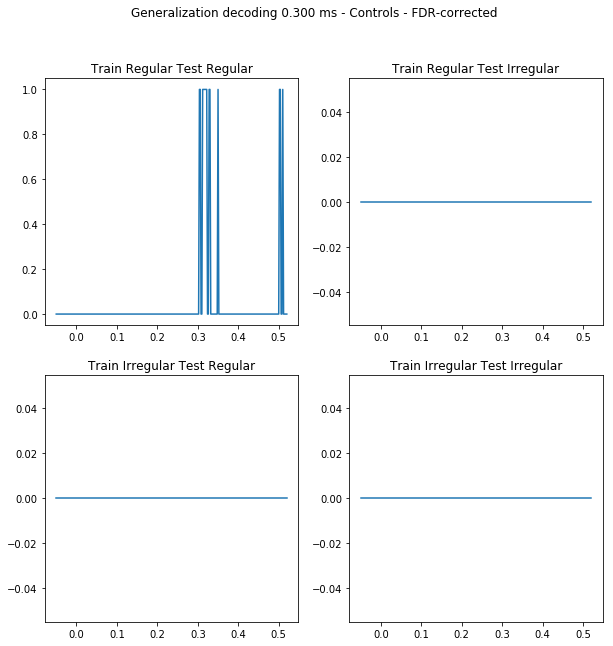

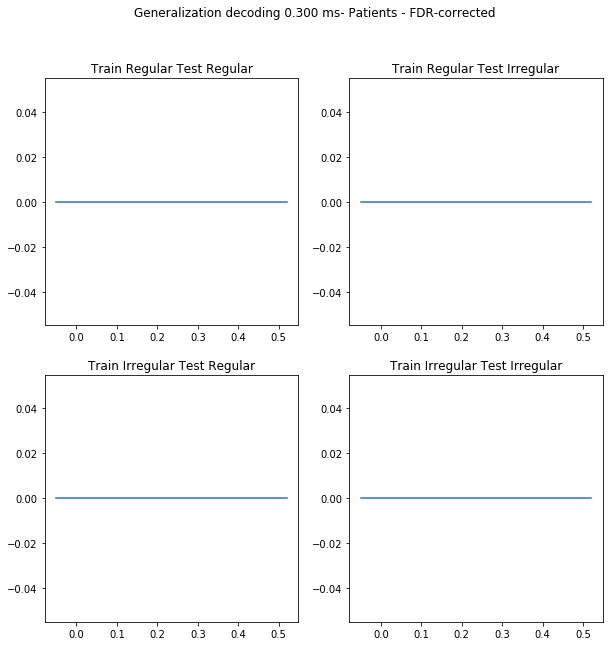

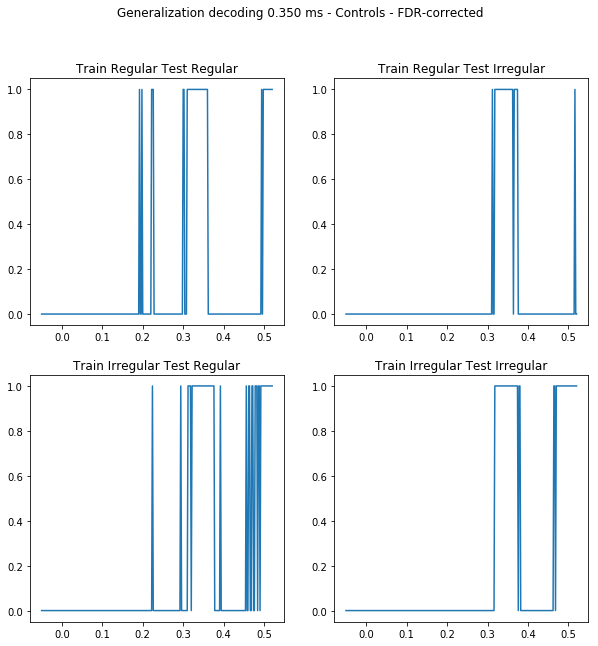

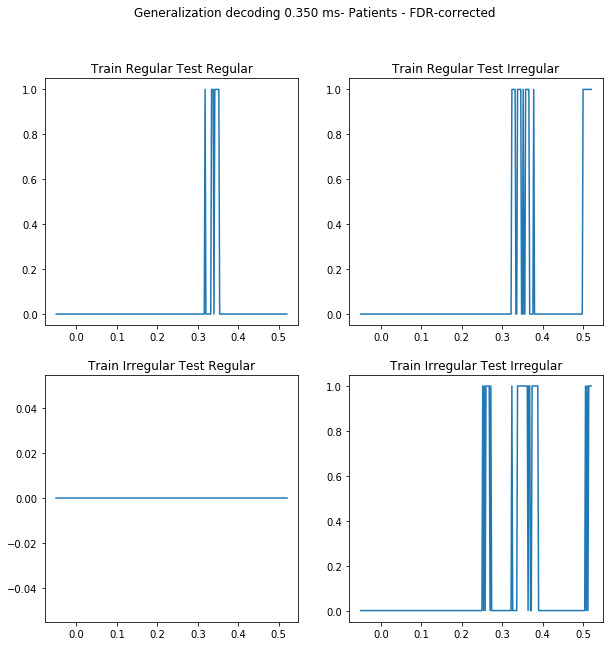

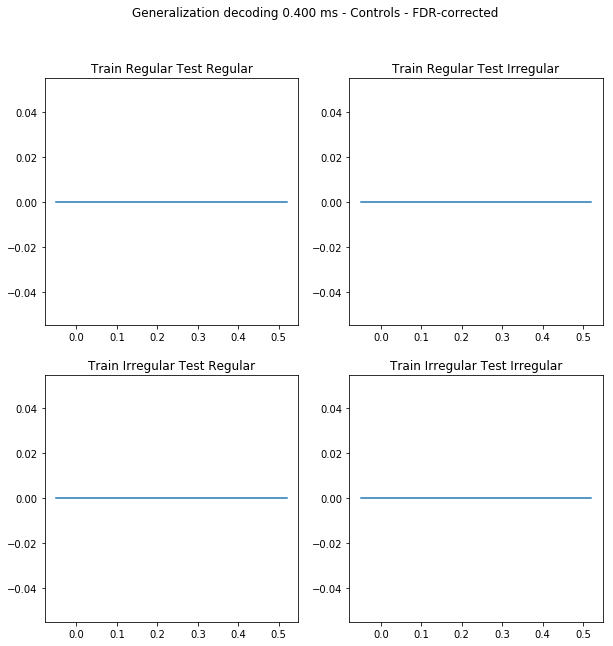

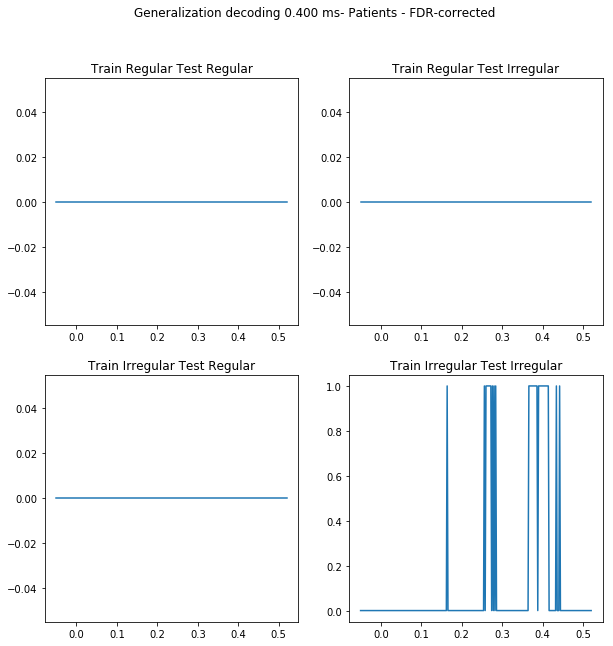

In [77]:
for curtp_ind in [175,200,225]:

    offdiag_sig_fdr_controls = offdiagonal_group(controls_id,statspath,curtp_ind)
    offdiag_sig_fdr_patients = offdiagonal_group(patients_id,statspath,curtp_ind)


    subtitles = ['Train Regular Test Regular',
                'Train Regular Test Irregular',
                'Train Irregular Test Regular',
                'Train Irregular Test Irregular']


    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_controls[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms - Controls - FDR-corrected' % timevec[curtp_ind])
    plt.show()


    plt.figure(figsize=(10,10))


    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_patients[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms- Patients - FDR-corrected' % timevec[curtp_ind])
    plt.show()


Step 3a - Across subjects statistics for controls 

In [78]:
for subj in controls_id:
    cursubj = os.path.join(statspath,subj)
    curpvals = np.load(cursubj)['proba'].mean(axis=1)
    

In [87]:
timepoints = np.array([ timevec[0],  timevec[-1],   timevec[0],  timevec[-1]])

In [91]:
curpvals.shape

(4, 2, 286, 286)

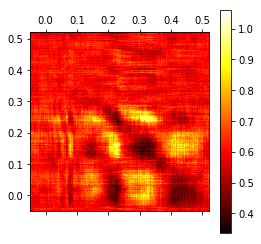

In [90]:
plt.matshow(-np.log10(curpvals[0][0]),extent=timepoints,cmap=plt.cm.hot)

plt.colorbar()

In [84]:
plt.imshow?

Step 3b - Across subjects statistics for patients 